In [230]:
#| include: false

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from itertools import combinations
import numpy as np
from matplotlib.patches import Patch
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings
from sklearn.metrics import confusion_matrix

In [237]:
#| include: false

import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)
df_train["loan_int_rate"] = df_train["loan_int_rate"] / 100
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,0.0991,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,0.1347,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,0.0751,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,0.1287,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,0.0963,0,0.28,N,10


# Abstract
In this blog post, we will be exploring bank loan data, specifically inquiring about the ability to predict loan success based on borrower characteristics. The data includes information about the borrower, loan amount, loan status, and other relevant information. Loan status is the target variable, where 1 indicates a default and 0 means the loan was repaid. We will test different combinations of features with a Logistic Regression model to discover the most predictive indicators of loan success. We will then discuss the results including an investigation of how different groups would be affected if the model were to be implemented.

# Explore the Data

## Summary Statistics
The first task is to explore the data, and understand the distribution of the features as they relate to the target variable. We will start by grouping the data by the target variable and calculating the mean of each feature. This will give us an idea of how the features differ between the two groups.


In [238]:
df_stats = df_train.copy()
df_stats["cb_person_default_on_file"] = (df_stats["cb_person_default_on_file"] == "Y").astype(int)
df_stats["loan_status"] = df_stats["loan_status"].map({1: "Default", 0: "Repaid"})
summary_table = df_stats.groupby("loan_status").mean(numeric_only=True)
home_ownership_percentages = df_stats.groupby("loan_status")["person_home_ownership"].value_counts(normalize=True).unstack(fill_value=0)
loan_intent_percentages = df_stats.groupby("loan_status")["loan_intent"].value_counts(normalize=True).unstack(fill_value=0)
final_summary = summary_table.join(home_ownership_percentages).join(loan_intent_percentages)
final_summary.reset_index(inplace=True)
final_summary.columns = final_summary.columns.str.replace('_', ' ').str.title()
final_summary = final_summary.round(3)

display(final_summary)

,Loan Status,Person Age,Person Income,Person Emp Length,Loan Amnt,Loan Int Rate,Loan Percent Income,Cb Person Default On File,Cb Person Cred Hist Length,Mortgage,Other,Own,Rent,Debtconsolidation,Education,Homeimprovement,Medical,Personal,Venture
0,Default,27.439,48883.177,4.159,10769.053,0.131,0.246,0.303,5.652,0.236,0.005,0.030,0.729,0.212,0.157,0.135,0.224,0.151,0.121
1,Repaid,27.817,70727.745,4.954,9235.881,0.104,0.149,0.140,5.834,0.460,0.003,0.094,0.443,0.146,0.208,0.105,0.175,0.174,0.193


Looking solely at the means, we see some interesting differences between defaulted and repaid loans. For example, as one would expect, defaulted loans have a higher average loan percent of income and interest rate. This makes sense because if a loan is a larger percent of ones income, it is harder to pay off. Similarly, a higher interest rate would make it more difficult to pay off the loan. It is also interesting to see that 73% of defaulted loans are taken out by individuals who rent their homes, compared to only 44% for repaid loans. This could be due to the fact that renters have less disposable income than homeowners. Finally, the loan amount averages is curious because the average loan amount doesn't differ that much between groups. One would expect that defaulted loans would have a higher average loan amount, but this is only slightly the case.

## Visualizations
To get a better idea of the characteristics of the data, we will continue by plotting some of the more interesting variables. We will scatter two continuous variables against each other, and color the points by the outcome of the loan. This will give us more of an idea of the relationships than the mean can give us. We will also calculate a line of best fit for each pairing to get a sense for whether the relationship is particularly predictive.

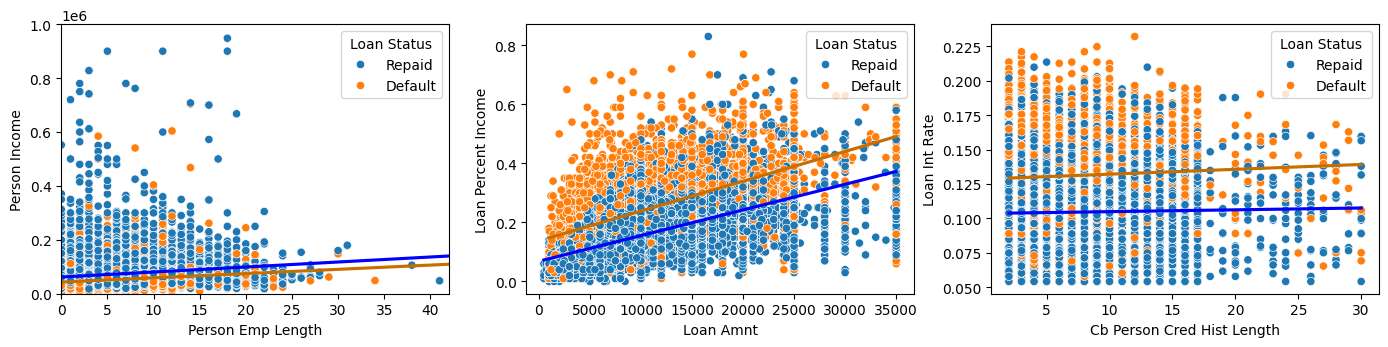

In [239]:
df_vis = df_train.copy()
df_vis["loan_status"] = df_vis["loan_status"].map({1: "Default", 0: "Repaid"})
df_vis.columns = df_vis.columns.str.replace('_', ' ').str.title()

fig, ax = plt.subplots(1, 3, figsize=(17, 3.5))

# define colors for each loan_status
palette = ["blue", "#C76E00"]

p1 = sns.scatterplot(df_vis, x="Person Emp Length", y="Person Income", hue="Loan Status", ax=ax[0])
ax[0].set_xlim(0, 42)
ax[0].set_ylim(0, 1000000)  # To remove outliers
for i, status in enumerate(df_vis["Loan Status"].unique()):
    subset = df_vis[df_vis["Loan Status"] == status]
    sns.regplot(data=subset, x="Person Emp Length", y="Person Income", scatter=False, ci=None, ax=ax[0], color=palette[i])

p2 = sns.scatterplot(df_vis, x="Loan Amnt", y="Loan Percent Income", hue="Loan Status", ax=ax[1])
for i, status in enumerate(df_vis["Loan Status"].unique()):
    subset = df_vis[df_vis["Loan Status"] == status]
    sns.regplot(data=subset, x="Loan Amnt", y="Loan Percent Income", scatter=False, ci=None, ax=ax[1], color=palette[i])

p3 = sns.scatterplot(df_vis, x="Cb Person Cred Hist Length", y="Loan Int Rate", hue="Loan Status", ax=ax[2])
for i, status in enumerate(df_vis["Loan Status"].unique()):
    subset = df_vis[df_vis["Loan Status"] == status]
    sns.regplot(data=subset, x="Cb Person Cred Hist Length", y="Loan Int Rate", scatter=False, ci=None, ax=ax[2], color=palette[i])

plt.show()


The first plot of income vs employment length is interesting because it is contrary to what we observed in the summary statistics. Both income and employment length appear to have very little between them when it comes to loan status. The lines of best fit for each group almost overlap indicating that the difference between groups is marginal. This is surprising because the summary statistics showed that the average income of borrowers who repay their loans is over $20,000 higher than those who default. This is a case where means can be deceiving because a lot of that difference can be accounted for by a few outliers with very high incomes. The lines of best fit recognize this and show that the relationship is not as strong as the mean would suggest.

The second plot of loan amount vs loan percent of income is more in line with what we would expect. The line of best fit for defaulted loans is steeper and higher than that of repaid loans, indicating that the loan amount is more predictive of loan status than income. This makes sense because the relative size of a loan to one's income is a better indicator of whether they can pay it back than income alone. Finally, the third plot shows the interest rate against the credit history length. The lines of best fit are very separated indicating that interest rate has a significant impact on ability to repay as we anticipated. 

# Build a Model

## Data Preprocessing
The next step is to train a model on the data. The first thing we need to do, in order to accomplish this, is to preprocess the data. This involves removing the target variable from the feature set and using one-hot encoding to binarize the categorical variables.


In [240]:
le = LabelEncoder()
le.fit(df_train["loan_status"])

def prepare_data(df):
  df = df.dropna()
  y = le.transform(df["loan_status"])
  x = df.drop(["loan_status", "loan_grade"], axis = 1)
  x = pd.get_dummies(x)
  return x, y

X_train, y_train = prepare_data(df_train)
X_train = X_train.reset_index(drop=True)

X_train.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,27,98000,3.0,11750,0.1347,0.12,6,False,False,False,True,False,True,False,False,False,False,False,True
1,22,36996,5.0,10000,0.0751,0.27,4,False,False,False,True,False,True,False,False,False,False,True,False
2,24,26000,2.0,1325,0.1287,0.05,4,False,False,False,True,False,False,False,True,False,False,True,False
3,29,53004,2.0,15000,0.0963,0.28,10,True,False,False,False,False,False,True,False,False,False,True,False
4,21,21700,2.0,5500,0.1491,0.25,2,False,False,False,True,False,False,True,False,False,False,True,False


## Feature Selection
With the data processed, we now need to determine which features to include in the model. To do this we will perform an exhaustive search of every combination of 3 features and use cross-validation scores to compare them. The following code will perform these tests by training a logistic regression model on each combination of features and calculating the cross-validation score. The best combination of features will be the one with the highest cross-validation score.

In [241]:
warnings.filterwarnings('ignore')
attributes = X_train.columns
combs = list(combinations(attributes, 3))

tests = []

for cols in combs:
    LR = LogisticRegression()
    LR.fit(X_train[list(cols)], y_train)
    LR.score(X_train[list(cols)], y_train)
    cv_scores = cross_val_score(LR, X_train[list(cols)], y_train, cv = 5)
    tests.append((list(cols), cv_scores.mean()))

To find the best combination we will sort by cross-validation score and display the top 5 combinations.

In [242]:
df_results = pd.DataFrame(tests, columns=["Columns", "Cross-Validation Score"])

df_results["Columns"] = df_results["Columns"].apply(lambda x: ", ".join(x))

pd.set_option("display.max_colwidth", None)  # no truncation of column text

df_results = df_results.sort_values(by="Cross-Validation Score", ascending=False) # sort by cross-val score
df_results.reset_index(drop=True, inplace=True)

df_results.head()


,Columns,Cross-Validation Score
0,"loan_percent_income, person_home_ownership_RENT, loan_intent_HOMEIMPROVEMENT",0.849521
1,"loan_percent_income, person_home_ownership_RENT, loan_intent_DEBTCONSOLIDATION",0.849260
2,"loan_percent_income, person_home_ownership_OTHER, person_home_ownership_RENT",0.849216
3,"loan_percent_income, person_home_ownership_MORTGAGE, person_home_ownership_OWN",0.848736
4,"loan_percent_income, person_home_ownership_RENT, loan_intent_MEDICAL",0.848430


As the above table shows, the combination of **loan percent of income**, **person home ownership: rent**, and **loan intent: home improvement** performs the best with a cross-validation score of 0.8495. This makes sense with our initial exploration as we recognized the big difference between groups in loan percent of income and home ownership status.

With the best combination of features determined, we can now train the model on the entire dataset and evaluate its performance. By training a logistic regression model on the training columns we are able to obtain a weight vector which can be used to score new data.

In [243]:
cols = df_results["Columns"].iloc[0].split(", ")
LR = LogisticRegression()
LR.fit(X_train[cols], y_train)
LR_train_score = LR.score(X_train[cols], y_train)
print(f"Training Score: {LR_train_score}")
w = LR.coef_[0]
print(f"Weight Vector (w): {w}")

Training Score: 0.8493473610686689
Weight Vector (w): [8.14642112 1.19649321 0.49192603]


Above we see the training score which matches the cross-validation score, as expected, as well as the weight vector which we will use in the next section to find a threshold.

# Find a Threshold
The next step is to determine a threshold past which to classify a loan as a predicted default. We will do this by computing a score for each loan using the dot product of the features and the learned weight vector. Now, with a score for every loan, we can test thresholds up to the maximum score and calculate the expected benefit for the bank at each threshold. This benefit depends on the loan amount and interest rate for each loan so we will have to add these to the computation.

The two outcomes we are interested in are the true negatives and the false negatives. This is the number of loans that were correctly predicted to be repaid and the number that were predicted to repay but instead defaulted. The predicted defaults are ignored because the bank would not have offered a loan so there would be no benefit. On the true negatives, the bank benefits from the interest rate on the loan but on the false negatives, the bank loses the loan amount. The benefit is calculated by summing the benefit from the true negatives and subtracting the benefit from the false negatives.

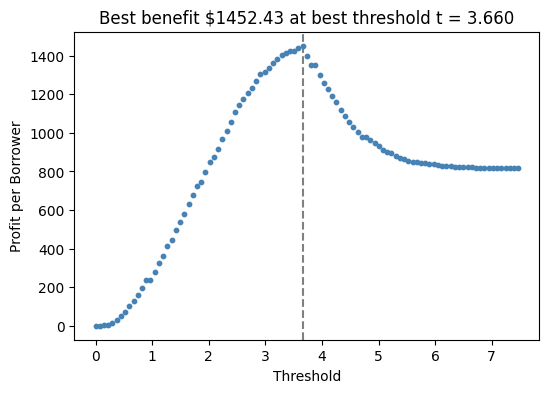

In [246]:
def linear_score(X, w):
    return X@w

best_benefit = 0
best_threshold = 0

s = linear_score(X_train[cols], w)

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

loan_amnt = X_train["loan_amnt"].values
loan_int_rate = X_train["loan_int_rate"].values

for t in np.linspace(0, max(s), 101):
    y_pred = s >= t

    benefit_good = (loan_amnt * (1 + 0.25 * loan_int_rate) ** 10) - loan_amnt
    benefit_bad = (loan_amnt * (1 + 0.25 * loan_int_rate) ** 3) - (1.7 * loan_amnt)

    benefit = np.where((~y_pred) & (y_train == 0), benefit_good, 0) + np.where((~y_pred) & (y_train == 1), benefit_bad, 0)

    benefit = benefit.mean()

    ax.scatter(t, benefit, color = "steelblue", s = 10)
    if benefit > best_benefit: 
        best_benefit = benefit
        best_threshold = t

ax.axvline(best_threshold, linestyle = "--", color = "grey", zorder = -10)
labs = ax.set(xlabel = r"Threshold", ylabel = "Profit per Borrower", title = f"Best benefit ${best_benefit:.2f} at best threshold t = {best_threshold:.3f}")

As the above plot demonstrates, our model is most beneficial for the bank when the threshold is **3.66**, where the benefit per person is maximizes at $1452.43. This means that the bank would benefit the most by only offering loans to individuals with a score above 3.66.

In [253]:
#| include: false

url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)
df_test["loan_int_rate"] = df_test["loan_int_rate"] / 100
X_test, y_test = prepare_data(df_test)

# Evaluate from the Bank's Perspective

We can now use this threshold to predict the outcome of future loans, from the test set, and calculate the benefit.

In [259]:
t = best_threshold

# compute the scores
s = linear_score(X_test[cols], w)
preds = s >= t

loan_amnt = X_test["loan_amnt"].values
loan_int_rate = X_test["loan_int_rate"].values

benefit_good = (loan_amnt * (1 + 0.25 * loan_int_rate) ** 10) - loan_amnt
benefit_bad = (loan_amnt * (1 + 0.25 * loan_int_rate) ** 3) - (1.7 * loan_amnt)

benefit = np.where((~preds) & (y_test == 0), benefit_good, 0) + np.where((~preds) & (y_test == 1), benefit_bad, 0)
print(f"Expected Profit per Borrower: ${benefit.mean().round(2)}")


Expected Profit per Borrower: $1400.17


As we see, the expected profit per borrower with this threshold is **$1400.17** which is in line with the expected benefit we calculated with the training data. This means that the model is generalizing well and would be beneficial for the bank to implement.

# Evaluate from the Borrower’s Perspective
We next want to consider how the implementation of this model would affect borrowers. We will first look at different age groups by binning the ages and calculating the acceptance rate for each group. We will then calculate the acceptance rate for different income levels and loan purposes.

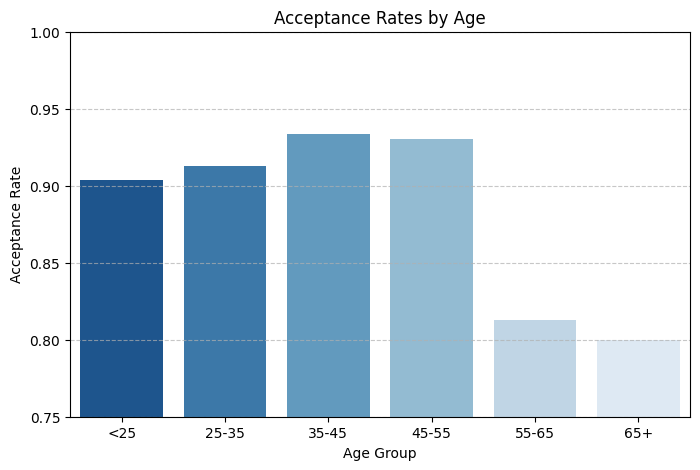

In [312]:
bins = [X_test["person_age"].min(), 25, 35, 45, 55, 65, X_test["person_age"].max()]
labels = ["<25", "25-35", "35-45", "45-55", "55-65", "65+"]

X_test["age_group"] = pd.cut(X_test["person_age"], bins=bins, labels=labels, include_lowest=True)

acceptance_rates_age = X_test.groupby("age_group").apply(lambda group: np.mean(preds[group.index] == 0))

plt.figure(figsize=(8, 5))
sns.barplot(x=acceptance_rates_age.index, y=acceptance_rates_age.values, palette="Blues_r")

plt.xlabel("Age Group")
plt.ylabel("Acceptance Rate")
plt.title("Acceptance Rates by Age")
plt.ylim(0.75, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

As the plot above shows, the acceptance rate is a bell curve with people between 35 and 55 having the highest acceptance rate. This makes logical sense because younger people are less settled and thus more risky to lend to while death becomes a worry when lending to older people. People in the middle are more likely to have stable jobs and thus be able to pay back the loan.

In [314]:
X_test["predict_default"] = preds
X_test["loan_status"] = y_test

medical = X_test.groupby("loan_intent_MEDICAL")[["predict_default", "loan_status"]].mean().reset_index()
venture = X_test.groupby("loan_intent_VENTURE")[["predict_default", "loan_status"]].mean().reset_index()
education = X_test.groupby("loan_intent_EDUCATION")[["predict_default", "loan_status"]].mean().reset_index()

medical = medical.rename(columns={"loan_intent_MEDICAL": "Medical", "predict_default": "Predicted Default Rate", "loan_status": "Actual Default Rate"})
venture = venture.rename(columns={"loan_intent_VENTURE": "Business Venture", "predict_default": "Predicted Default Rate", "loan_status": "Actual Default Rate"})
education = education.rename(columns={"loan_intent_EDUCATION": "Education", "predict_default": "Predicted Default Rate", "loan_status": "Actual Default Rate"})

display(medical, venture, education)

,Medical,Predicted Default Rate,Actual Default Rate
0,False,0.086518,0.208673
1,True,0.103448,0.284250


,Business Venture,Predicted Default Rate,Actual Default Rate
0,False,0.091252,0.238305
1,True,0.081950,0.146266


,Education,Predicted Default Rate,Actual Default Rate
0,False,0.093304,0.237102
1,True,0.075680,0.167517


Looking at the default predictions by loan intent and comparing them with the actual outcome is also interesting. The predicted default rate for medical intended loans is higher than other loans, and the actual default rate reflects this trend as well. This makes sense because medical loans are often taken out of necessity rather than choice so the individuals involved don't have the luxury to consider whether or not they will be able to pay them back. Loans for business ventures and education, on the other hand, have a lower predicted default rate and this is reflected in the actual default rate as well. This is likely because these loans are taken out with the intention of making money in the future, so if that comes to pass these individuals will be able to repay their loans more easily.

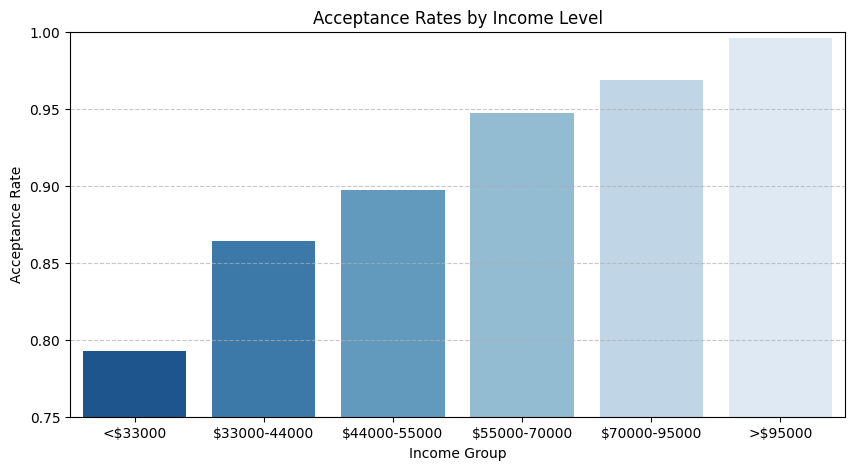

In [315]:
quartiles, bin_edges = pd.qcut(X_test["person_income"], q=6, retbins=True, labels=False)

labels = [f"${int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]
labels[0] = f"<${int(bin_edges[1])}"
labels[-1] = f">${int(bin_edges[-2])}"

X_test["income_group"] = pd.qcut(X_test["person_income"], q=6, labels=labels)

acceptance_rates_income = X_test.groupby("income_group").apply(lambda group: np.mean(preds[group.index] == 0))

plt.figure(figsize=(10, 5))
sns.barplot(x=acceptance_rates_income.index, y=acceptance_rates_income.values, palette="Blues_r")

plt.xlabel("Income Group")
plt.ylabel("Acceptance Rate")
plt.title("Acceptance Rates by Income Level")
plt.ylim(0.75, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)

Finally, we will look at acceptance rates by income level. As the chart above shows, this is a pretty linear relationship with higher income individuals being more likely to be accepted for a loan. This makes sense because people with more money have more money with which to pay back the loan.

# Discussion
The primary results are that, by using **loan percent of income**, **person home ownership: rent**, and **loan intent: home improvement** as predictor variables and a threshold of **3.66**, with a Logistic Regression model, a bank can expect to make around **$1,400** profit per borrower. Looking at these results, a few conclusions immediately jump to mind. First, for banks, the model would be very beneficial as it is more efficient than determining loans manually and allows them to maximize profit which is their goal. For borrowers, however, this model has the potential to be problematic. As with any data driven decision making process, data has the potential to lose important context and nuances about the individuals involved. For example, the model may be biased against certain groups of borrowers because the historical data that it was trained on was also biased. This has the potential to create a self perpetuating cycle where certain groups are always disadvantaged. This drawback must be weighed when considering the implementation of such a model.

The question of fairness around medical debt is an interesting and difficult one. On the one hand, as we observed, medical loans are more likely to default that other loans, so from a banks perspective it doesn't make sense to offer such loans. However, from a moral perspective, it is difficult to justify not offering loans for potentially life saving medical procedures. This is a case where the model is not perfect and the bank would have to weigh the potential profit against the moral implications of not offering loans to those who need them. Logically, it is _fair_ that it is more difficult to get a loan if you are less likely to pay it back but I think it is fair to say that most people would deem loan denials for medical procedures as unfair since ability to pay shouldn't impact ability to live.